## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

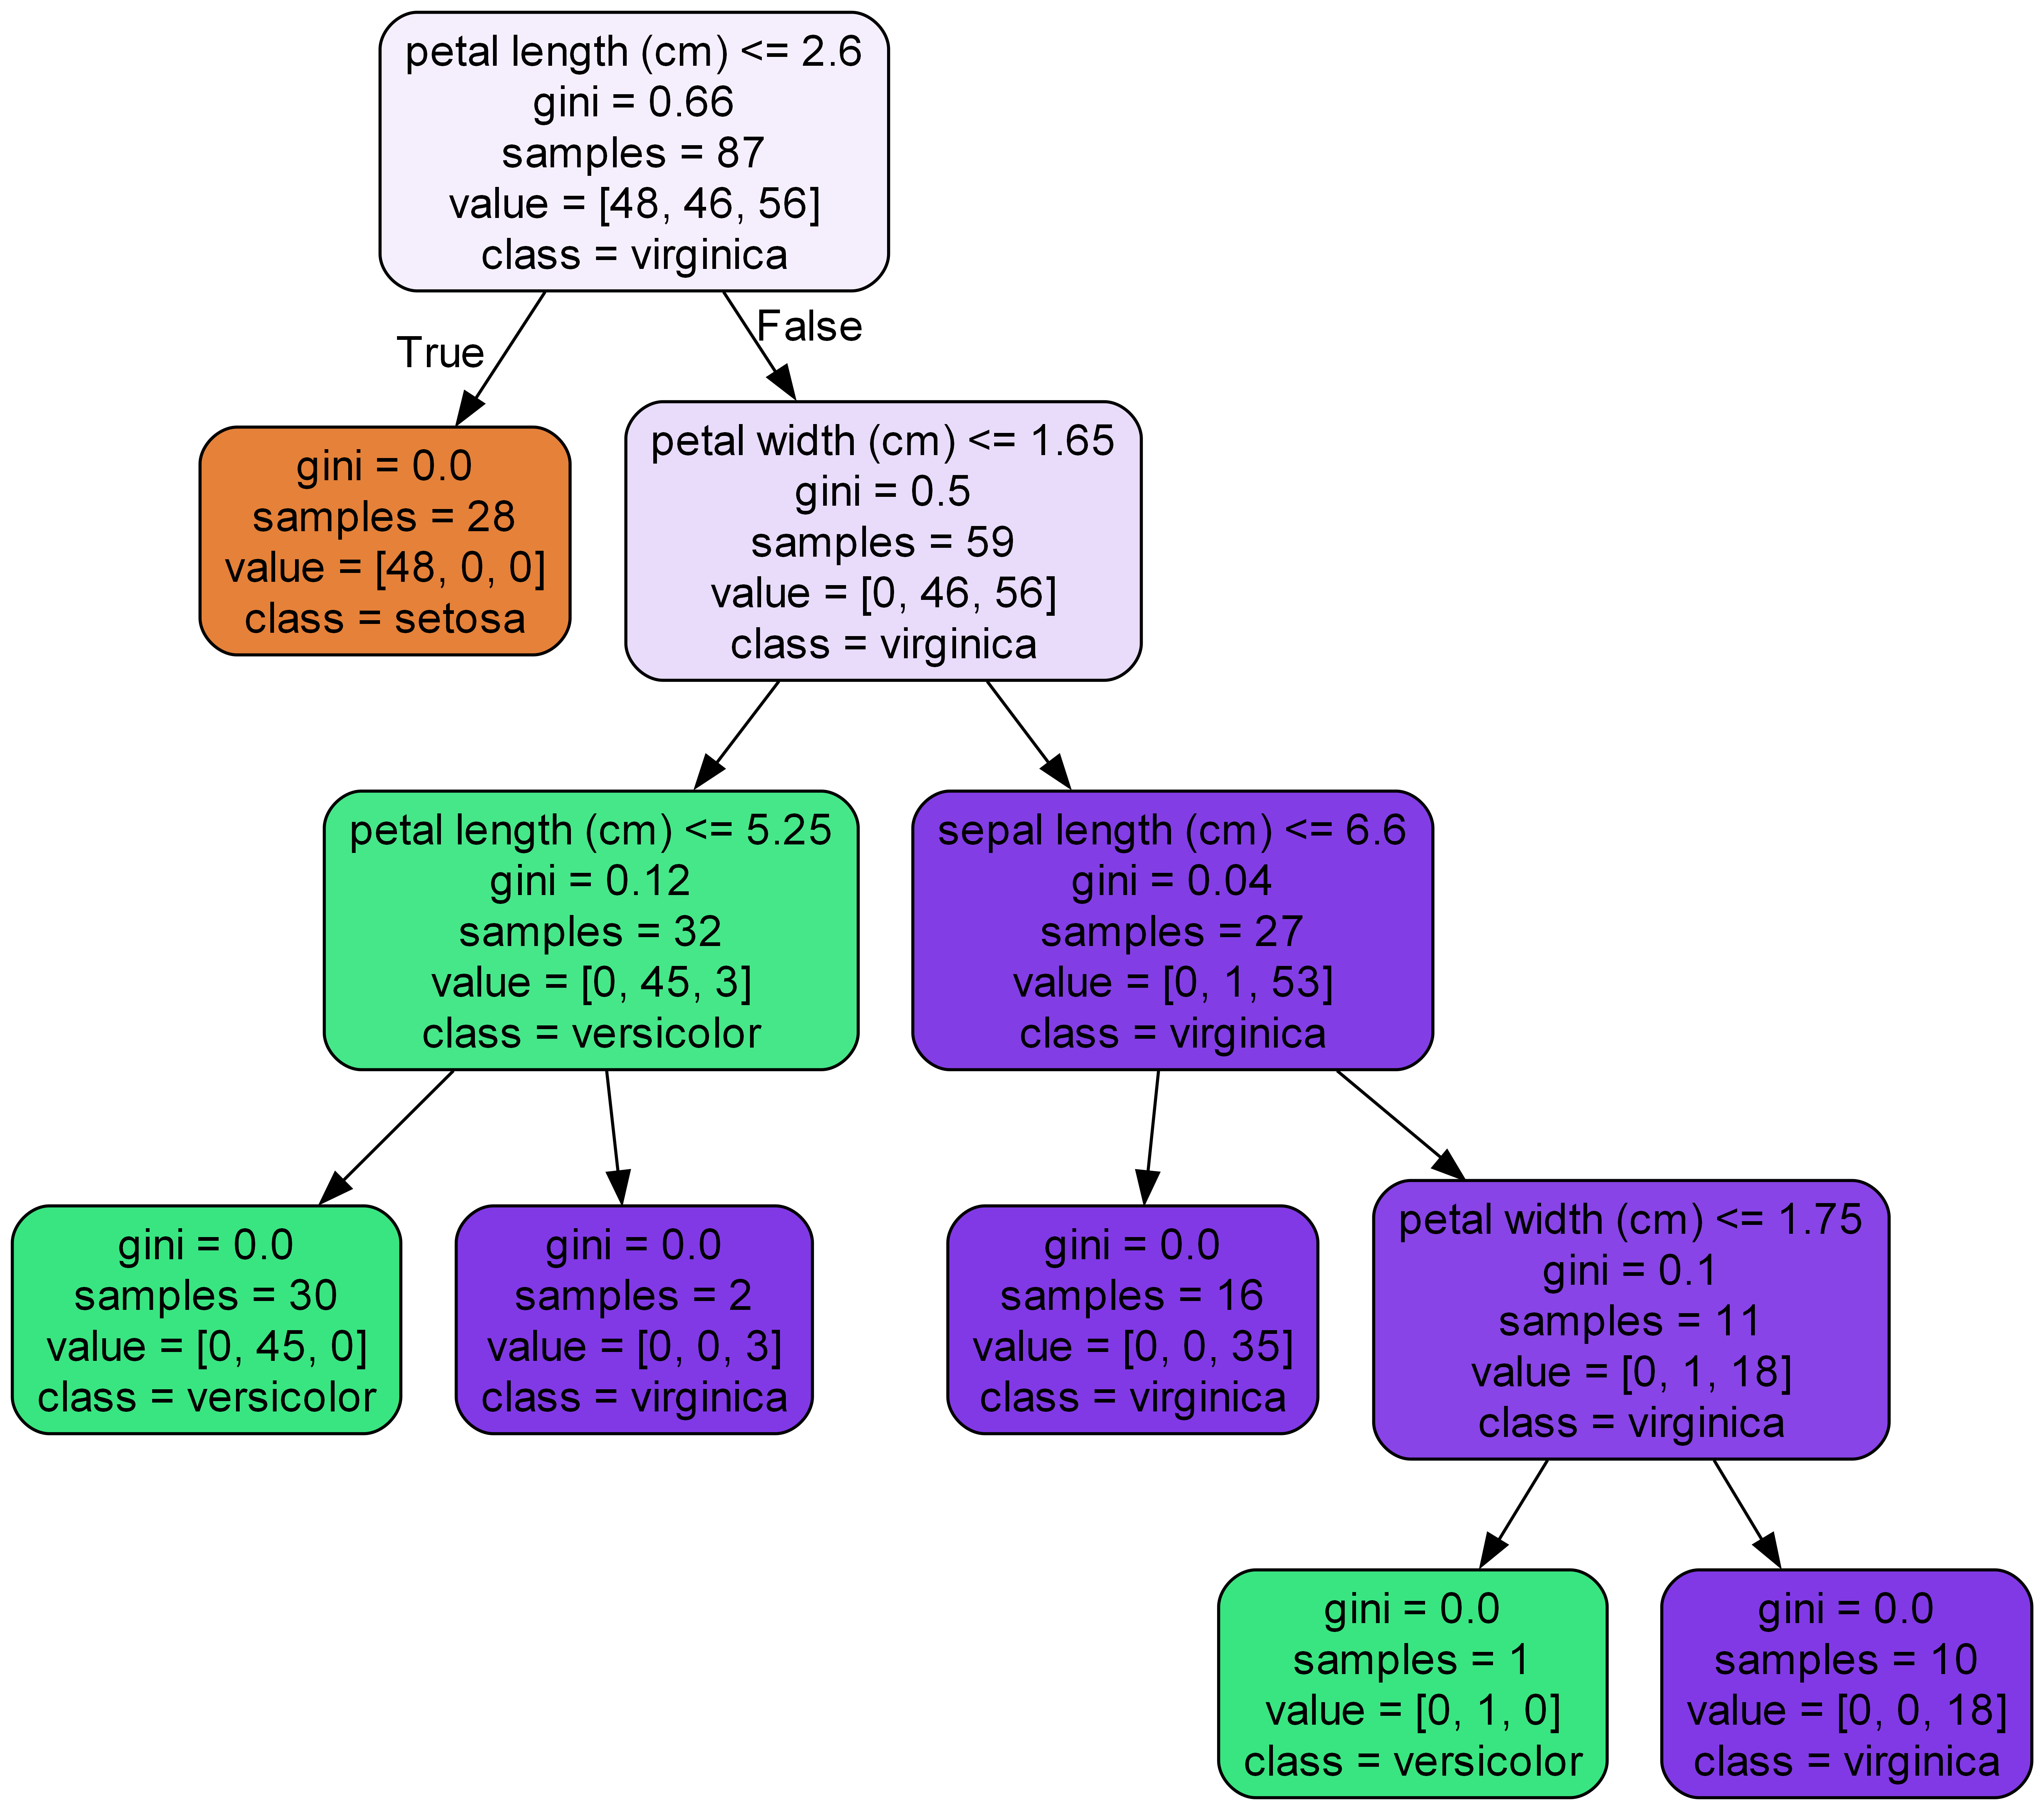

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [7]:
df['n_age'] = 2024 - df['birth_year']
df['n_age'].head()

0    60.0
1    37.0
2    60.0
3    33.0
4    32.0
Name: n_age, dtype: float64

In [8]:
# drop 'birth_year' after caculation
df.drop('birth_year', axis=1, inplace=True)

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [9]:
df.isnull().sum()

patient_id               0
global_num             904
sex                    145
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   age                 1957 non-null   object 
 4   country             2218 non-null   object 
 5   province            2218 non-null   object 
 6   city                2153 non-null   object 
 7   disease             19 non-null     object 
 8   infection_case      1163 non-null   object 
 9   infection_order     42 non-null     float64
 10  infected_by         469 non-null    float64
 11  contact_number      411 non-null    float64
 12  symptom_onset_date  193 non-null    object 
 13  confirmed_date      2077 non-null   object 
 14  released_date       223 non-null    object 
 15  deceased_date       32 non-null     object 
 16  state 

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [11]:
df['disease'].value_counts()

True    19
Name: disease, dtype: int64

In [12]:
# Replace missing values in 'disease' column with 0
df['disease'].fillna('NO', inplace=True)

# Replace True values in 'disease' column with 1
df['disease'] = df['disease'].replace(True, 'YES')

df['disease'].value_counts()

NO     2199
YES      19
Name: disease, dtype: int64

I didn't follow the instruction but I used 'NO' and 'YES' to replace 'NA' and 'True' because they will be transfered by getdummy later.

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [13]:
# List of columns to fill null values with mean
columns_to_fill = ['global_num', 'infection_order', 'infected_by', 'contact_number']

# Fill null values in the specified columns with their mean
for column in columns_to_fill:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [14]:
# Assume 'symptom_onset_date' has missing values because patients confirmed Covid-Positive the same date.
# Fill missing values in 'symptom_onset_date' with values from 'confirmed_date'

df['symptom_onset_date'].fillna(df['confirmed_date'], inplace=True)

In [15]:
df['age'].value_counts()

20s     467
50s     385
40s     303
30s     251
60s     229
70s     117
80s      84
10s      74
0s       29
90s      17
100s      1
Name: age, dtype: int64

In [16]:
# Mapping dictionary for age ranges to specific ages
age_mapping = {
    '0s': 5,
    '10s': 15,
    '20s': 25,
    '30s': 35,
    '40s': 45,
    '50s': 55,
    '60s': 65,
    '70s': 75,
    '80s': 85,
    '90s': 95,
    '100s': 105
}

# Apply the mapping to the 'age' column
df['age'] = df['age'].map(age_mapping)

In [17]:
# Fill missing values in 'n_age' with values from 'age'
df['n_age'].fillna(df['age'], inplace=True)

# Drop age column and leave 'n_age' as variance
df = df.drop(columns=['age'])

df['n_age'].isnull().sum()

151

In [18]:
mean_age = df['n_age'].mean()
# Fill missing values in 'age' column with the mean value
df['n_age'].fillna(mean_age, inplace=True)

In [19]:
# Check values in 'infection_case' column
df['infection_case'].value_counts()

contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
River of Grace Community Church       1
Pilgrimage to Israel                  1
Name: infection_case, dtype: int64

In [20]:
# Drop column 'infection_case' becasue of too many missing values and 'etc'.
df = df.drop('infection_case', axis=1)

In [21]:
df['country'].value_counts()

Korea       2206
China         10
Mongolia       1
Thailand       1
Name: country, dtype: int64

In [22]:
df[df['country'] != 'Korea'][['country', 'province', 'city']]

,country,province,city
10,China,Seoul,Seodaemun-gu
29,China,Seoul,Gangdong-gu
38,China,Seoul,Geumcheon-gu
288,China,Busan,NaN
464,China,Incheon,Wuhan
591,China,Gyeonggi-do,Bucheon-si
592,China,Gyeonggi-do,Goyang-si
598,China,Gyeonggi-do,Siheung-si
599,China,Gyeonggi-do,Goyang-si
627,Mongolia,Gyeonggi-do,Namyangju-si


It seems the data in these columns are a little bit messy here. Most of the rows here are obviously wrong inputs.

In [23]:
# drop 'country', 'province', 'city' columns
df = df.drop(columns=['country', 'province', 'city'])

In [24]:
# Drop rows where 'sex' column has missing values because there are only 145 missing values.
df = df.dropna(subset=['sex'])

 **<font color='teal'> Check for any remaining null values.</font>**

In [25]:
df.isnull().sum()

patient_id               0
global_num               0
sex                      0
disease                  0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date       1
confirmed_date           1
released_date         1851
deceased_date         2041
state                   88
n_age                    0
dtype: int64

In [26]:
df.head()

,patient_id,global_num,sex,disease,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,NO,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,60.0
1,1000000002,5.0,male,NO,1.0,2.600789e+09,31.0,2020-01-30,2020-01-30,2020-03-02,NaN,released,37.0
2,1000000003,6.0,male,NO,2.0,2.002000e+09,17.0,2020-01-30,2020-01-30,2020-02-19,NaN,released,60.0
3,1000000004,7.0,male,NO,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,33.0
4,1000000005,9.0,female,NO,2.0,1.000000e+09,2.0,2020-01-31,2020-01-31,2020-02-24,NaN,released,32.0


Remove date columns from the data.


In [27]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [28]:
print(df.nunique())

patient_id         2073
global_num         1304
sex                   2
disease               2
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                97
dtype: int64


Review the percent of unique values by column.

In [29]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.629040
sex                0.000965
disease            0.000965
infection_order    0.003377
infected_by        0.099855
contact_number     0.035215
state              0.001447
n_age              0.046792
dtype: float64


Review the range of values per column.

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2073.0,3.876378e+09,2.201365e+09,1.000000e+09,1.600000e+09,4.100000e+09,6.001000e+09,7.000000e+09
global_num,2073.0,4.664817e+03,2.287868e+03,1.000000e+00,3.946000e+03,4.664817e+03,6.151000e+03,8.717000e+03
infection_order,2073.0,2.285714e+00,1.765328e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2073.0,2.600789e+09,7.464560e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2073.0,2.413239e+01,4.051856e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2073.0,4.837328e+01,1.937206e+01,4.000000e+00,3.100000e+01,4.835075e+01,6.200000e+01,1.080000e+02


### Check for duplicated rows

In [31]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,disease,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [32]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,disease,2
2,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [33]:
df.set_index('patient_id', inplace=True)

C:\Users\Dallen\AppData\Local\Temp\ipykernel_11028\651174168.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


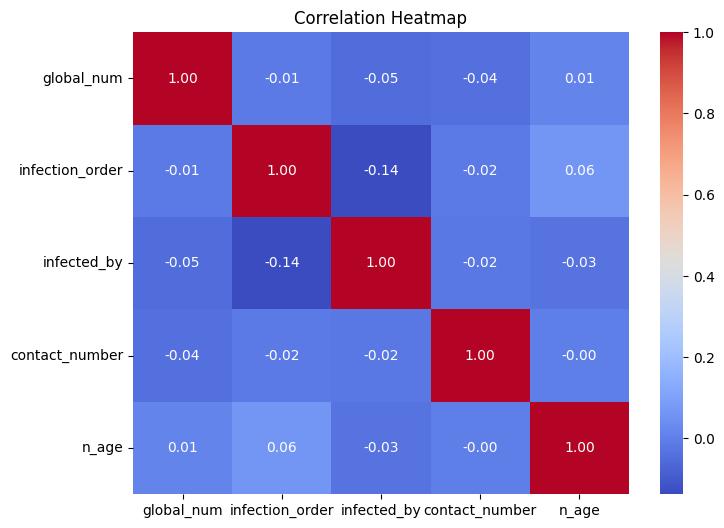

In [34]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

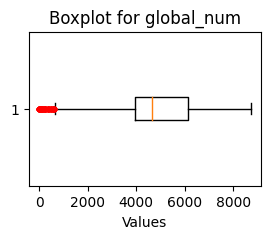

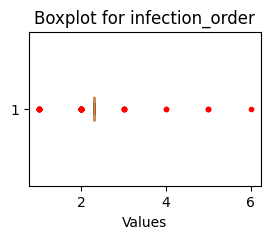

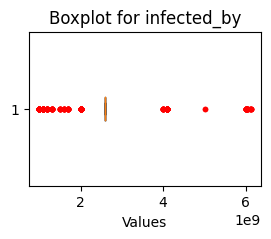

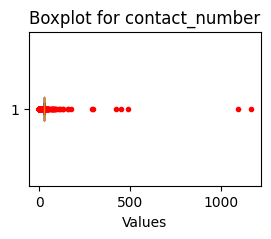

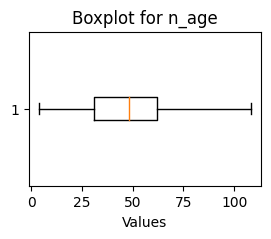

In [35]:
# Get a list of all numerical column names
numerical_columns = df.select_dtypes(include=['number']).columns

# Loop through each numerical column and create a separate boxplot
for column in numerical_columns:
    plt.figure(figsize=(3, 2))  # Set the figure size
    plt.boxplot(df[column], vert=False, sym='r.')  # Create the boxplot
    plt.title(f'Boxplot for {column}')  # Set the title
    plt.xlabel('Values')  # Set the x-axis label
    plt.show()  # Show the individual boxplot

In [36]:
# There are obvious outliers in column 'contact_number'
df[df['contact_number'] > 250]['contact_number']

patient_id
1100000001    1091.0
1100000007     485.0
1100000012     296.0
1200000031    1160.0
1300000001     450.0
2000000003     422.0
2000000006     290.0
Name: contact_number, dtype: float64

In [37]:
# Drop the four inputs
df = df[df['contact_number'] <= 250]

**<font color='teal'> Create dummy features for object type features. </font>**

In [38]:
# Get just those rows whose value for the 'state' column is null  
Prediction = df[df['state'].isnull()]
Prediction.describe()

,global_num,infection_order,infected_by,contact_number,n_age
count,88.000000,8.800000e+01,8.800000e+01,88.000000,88.000000
mean,8013.133138,2.285714e+00,2.120643e+09,23.728296,47.761364
std,1014.106778,1.339902e-15,3.088555e+08,2.729013,17.966120
min,4664.816591,2.285714e+00,1.000000e+09,2.000000,6.000000
25%,8219.500000,2.285714e+00,2.000000e+09,24.128954,35.750000
50%,8283.500000,2.285714e+00,2.000000e+09,24.128954,49.500000
75%,8378.500000,2.285714e+00,2.000000e+09,24.128954,61.000000
max,8565.000000,2.285714e+00,2.600789e+09,24.128954,87.000000


In [39]:
NOPrediction = df.dropna()
NOPrediction.describe()

,global_num,infection_order,infected_by,contact_number,n_age
count,1978.000000,1978.000000,1.978000e+03,1978.000000,1978.000000
mean,4525.247031,2.286003,2.622150e+09,22.115450,48.410923
std,2208.713576,0.180496,7.543575e+08,11.641768,19.451104
min,1.000000,1.000000,1.000000e+09,0.000000,4.000000
25%,3765.000000,2.285714,2.600789e+09,24.128954,31.000000
50%,4664.816591,2.285714,2.600789e+09,24.128954,48.350750
75%,5703.750000,2.285714,2.600789e+09,24.128954,62.000000
max,8717.000000,6.000000,6.113000e+09,174.000000,108.000000


In [40]:
# Check the names of the columns of NOPrediction
NOPrediction.columns

Index(['global_num', 'sex', 'disease', 'infection_order', 'infected_by',
       'contact_number', 'state', 'n_age'],
      dtype='object')

In [41]:
# Make a variable called 'features', and a list containing the strings of every column except "Decision"
features = ['global_num', 'sex', 'disease', 'infection_order', 'infected_by', 'contact_number', 'n_age']

In [42]:
# Make an explanatory variable called X, and assign it: NoPrediction[features]
X = NOPrediction[features]

# Make a dependent variable called y, and assign it: NoPrediction.Decision
y = NOPrediction.state

In [43]:
# One-hot encode all features in X.
X = pd.get_dummies(X)

In [44]:
X.head()

,global_num,infection_order,infected_by,contact_number,n_age,sex_female,sex_male,disease_NO,disease_YES
patient_id,,,,,,,,,
1000000001,2.0,1.0,2.600789e+09,75.0,60.0,0,1,1,0
1000000002,5.0,1.0,2.600789e+09,31.0,37.0,0,1,1,0
1000000003,6.0,2.0,2.002000e+09,17.0,60.0,0,1,1,0
1000000004,7.0,1.0,2.600789e+09,9.0,33.0,0,1,1,0
1000000005,9.0,2.0,1.000000e+09,2.0,32.0,1,0,1,0


### Split the data into test and train subsamples

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [47]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [48]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [49]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.861
Random Forest: f1-score=0.848


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [50]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  3   3   0]
 [  0 319  16]
 [  0  36  19]]
Normalized confusion matrix
[[0.5  0.5  0.  ]
 [0.   0.95 0.05]
 [0.   0.65 0.35]]


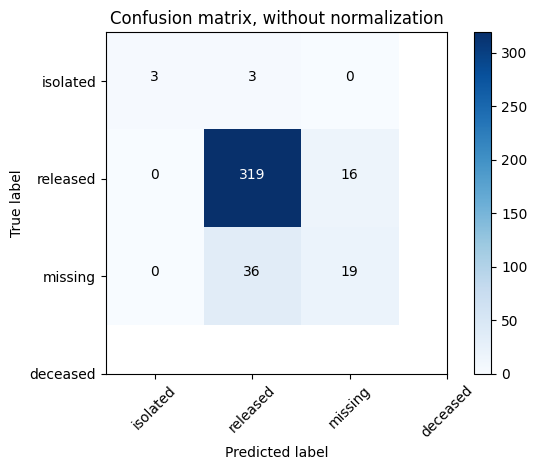

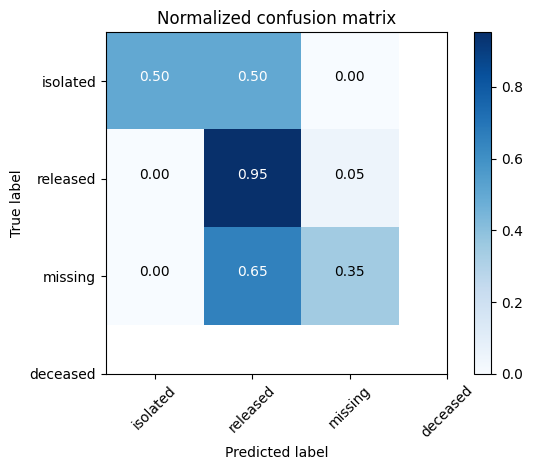

In [51]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

9


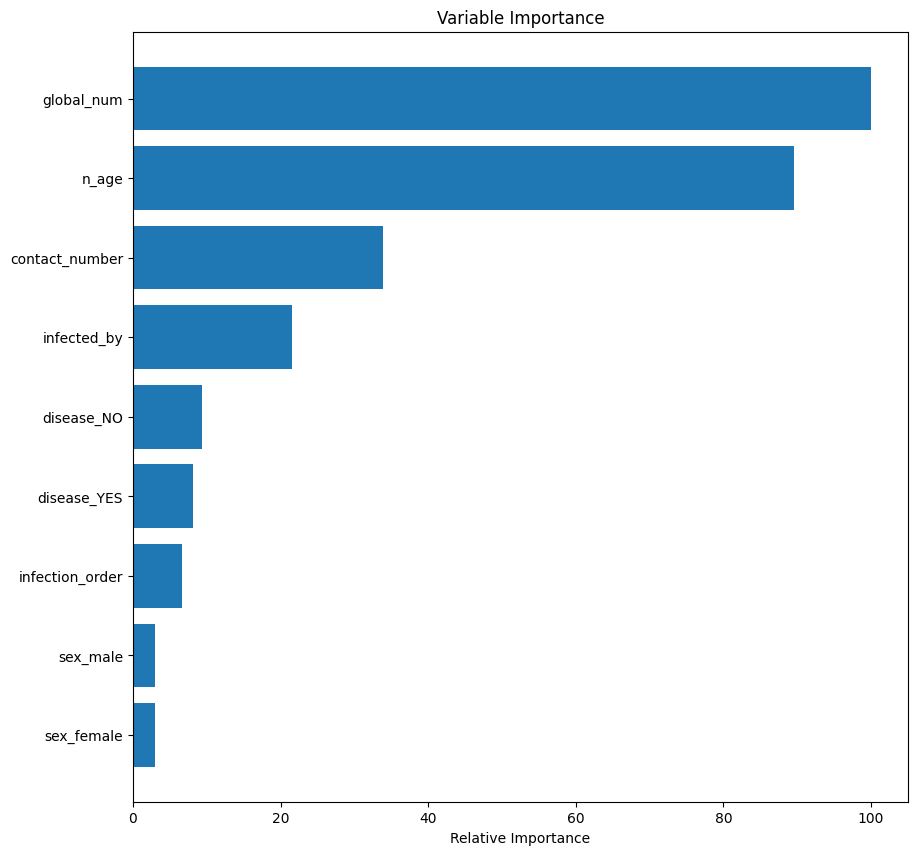

In [52]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.